In [1]:
from numba import njit
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
from scipy.interpolate import griddata
from scipy.integrate import simps
import pandas as pd
from multiprocessing import Pool
import itertools as it
from scipy.ndimage import gaussian_filter


# Loading and Combining Interpolated Fields
For taking fields from Comsole and combining them

In [2]:
# Load the fields individually
thz052 = np.load('f=0.52THz_interp.npz')
thz063 = np.load('f=0.63THz_interp.npz')
thz072 = np.load('f=0.72THz_interp.npz')
thz082 = np.load('f=0.82THz_interp.npz')

In [3]:
# Load components of each field here
#0.52 THz
e052 = {'Ex': thz052['Ex'], 'Ey': thz052['Ey']}
#0.63 THz
e063 = {'Ex': thz063['Ex'], 'Ey': thz063['Ey']}
#0.72 THz
e072 = {'Ex': thz072['Ex'], 'Ey': thz072['Ey']}
#0.82 THz
e082 = {'Ex': thz082['Ex'], 'Ey': thz082['Ey']}

full_field = {'Ex': e052['Ex'] + e063['Ex'] + e072['Ex'] + e082['Ex'],
             'Ey': e052['Ey'] + e063['Ey'] + e072['Ey'] + e082['Ey']}

x = thz063['X']
y = thz052['Y']
extent=(min(x), max(x), min(y), max(y))

In [42]:
# Set the initial plotting parameters

# Colorblind friendly color scheme reordered for maximum efficiency
ok = {
    'blue': "#56B4E9",
    'orange': "#E69F00",
    'green': "#009E73",
    'amber': "#F5C710",
    'purple': "#CC79A7",
    'navy': "#0072B2",
    'red': "#D55E00",
    'black': "#000000",
    'yellow': "#F0E442",
    'grey': "#999999",
}

plt_params = {
        'figure.figsize': (8, 6),
        'figure.dpi': 300,
        'legend.fontsize': 16,
        'axes.labelsize': 16,
        'axes.titlesize': 16,
        'axes.prop_cycle': plt.cycler('color', (ok[_] for _ in ok)),
        'xtick.labelsize': 16,
        'ytick.labelsize': 16,
        'lines.linewidth': 3.5,
        'lines.markersize': 7
        }
plt.rcParams.update(plt_params)

In [ ]:
plt.figure(figsize=(6,8), dpi=300)
plt.imshow(np.abs(gaussian_filter(ex082, 20)) ** 2 + np.abs(gaussian_filter(ey082, 20)) ** 2, 
           interpolation='nearest',
           origin='lower',
           norm=SymLogNorm(linthresh=1e-3)
          )
plt.colorbar()

In [ ]:
plt.figure(figsize=(6,8), dpi=300)
plt.imshow(np.abs(e052[0][2000:8000]) ** 2 + np.abs(e052[1][2000:8000]) ** 2, 
           interpolation='nearest',
           origin='lower',
           norm=SymLogNorm(linthresh=1e-3)
          )
plt.colorbar()

In [46]:
cut = slice(2000, 8000)
pref = np.sqrt(0.5)


@njit
def get_I(E1x, E1y, E2x, E2y, φ):
    
    Ex = E1x + pref * np.exp(1j* φ) * E2x
    Ey = E1y + pref * np.exp(1j* φ) * E2y
    
    return np.abs(Ex) ** 2 + np.abs(Ey) ** 2


def phase_scan(E1, E2, φ):
    
    I_out = simps(get_I(E1['Ex'][cut, -1], E1['Ey'][cut, -1], 
                        E2['Ex'][cut, -1], E2['Ey'][cut, -1], φ))

    I_in = simps(get_I(E1['Ex'][cut, 0], E1['Ey'][cut, 0], 
                       E2['Ex'][cut, 0], E2['Ey'][cut, 0], φ))

    return I_out / I_in, I_out, I_in


In [47]:
phase = np.linspace(0, 2 * np.pi, 100)

results1 = [phase_scan(e052, e063, ϕ) for ϕ in phase]
results2 = [phase_scan(e063, e072, ϕ) for ϕ in phase]
results3 = [phase_scan(e072, e082, ϕ) for ϕ in phase]

Calculating the combination of 0.52THz and 0.63THz


KeyError: 'i\\varphi'

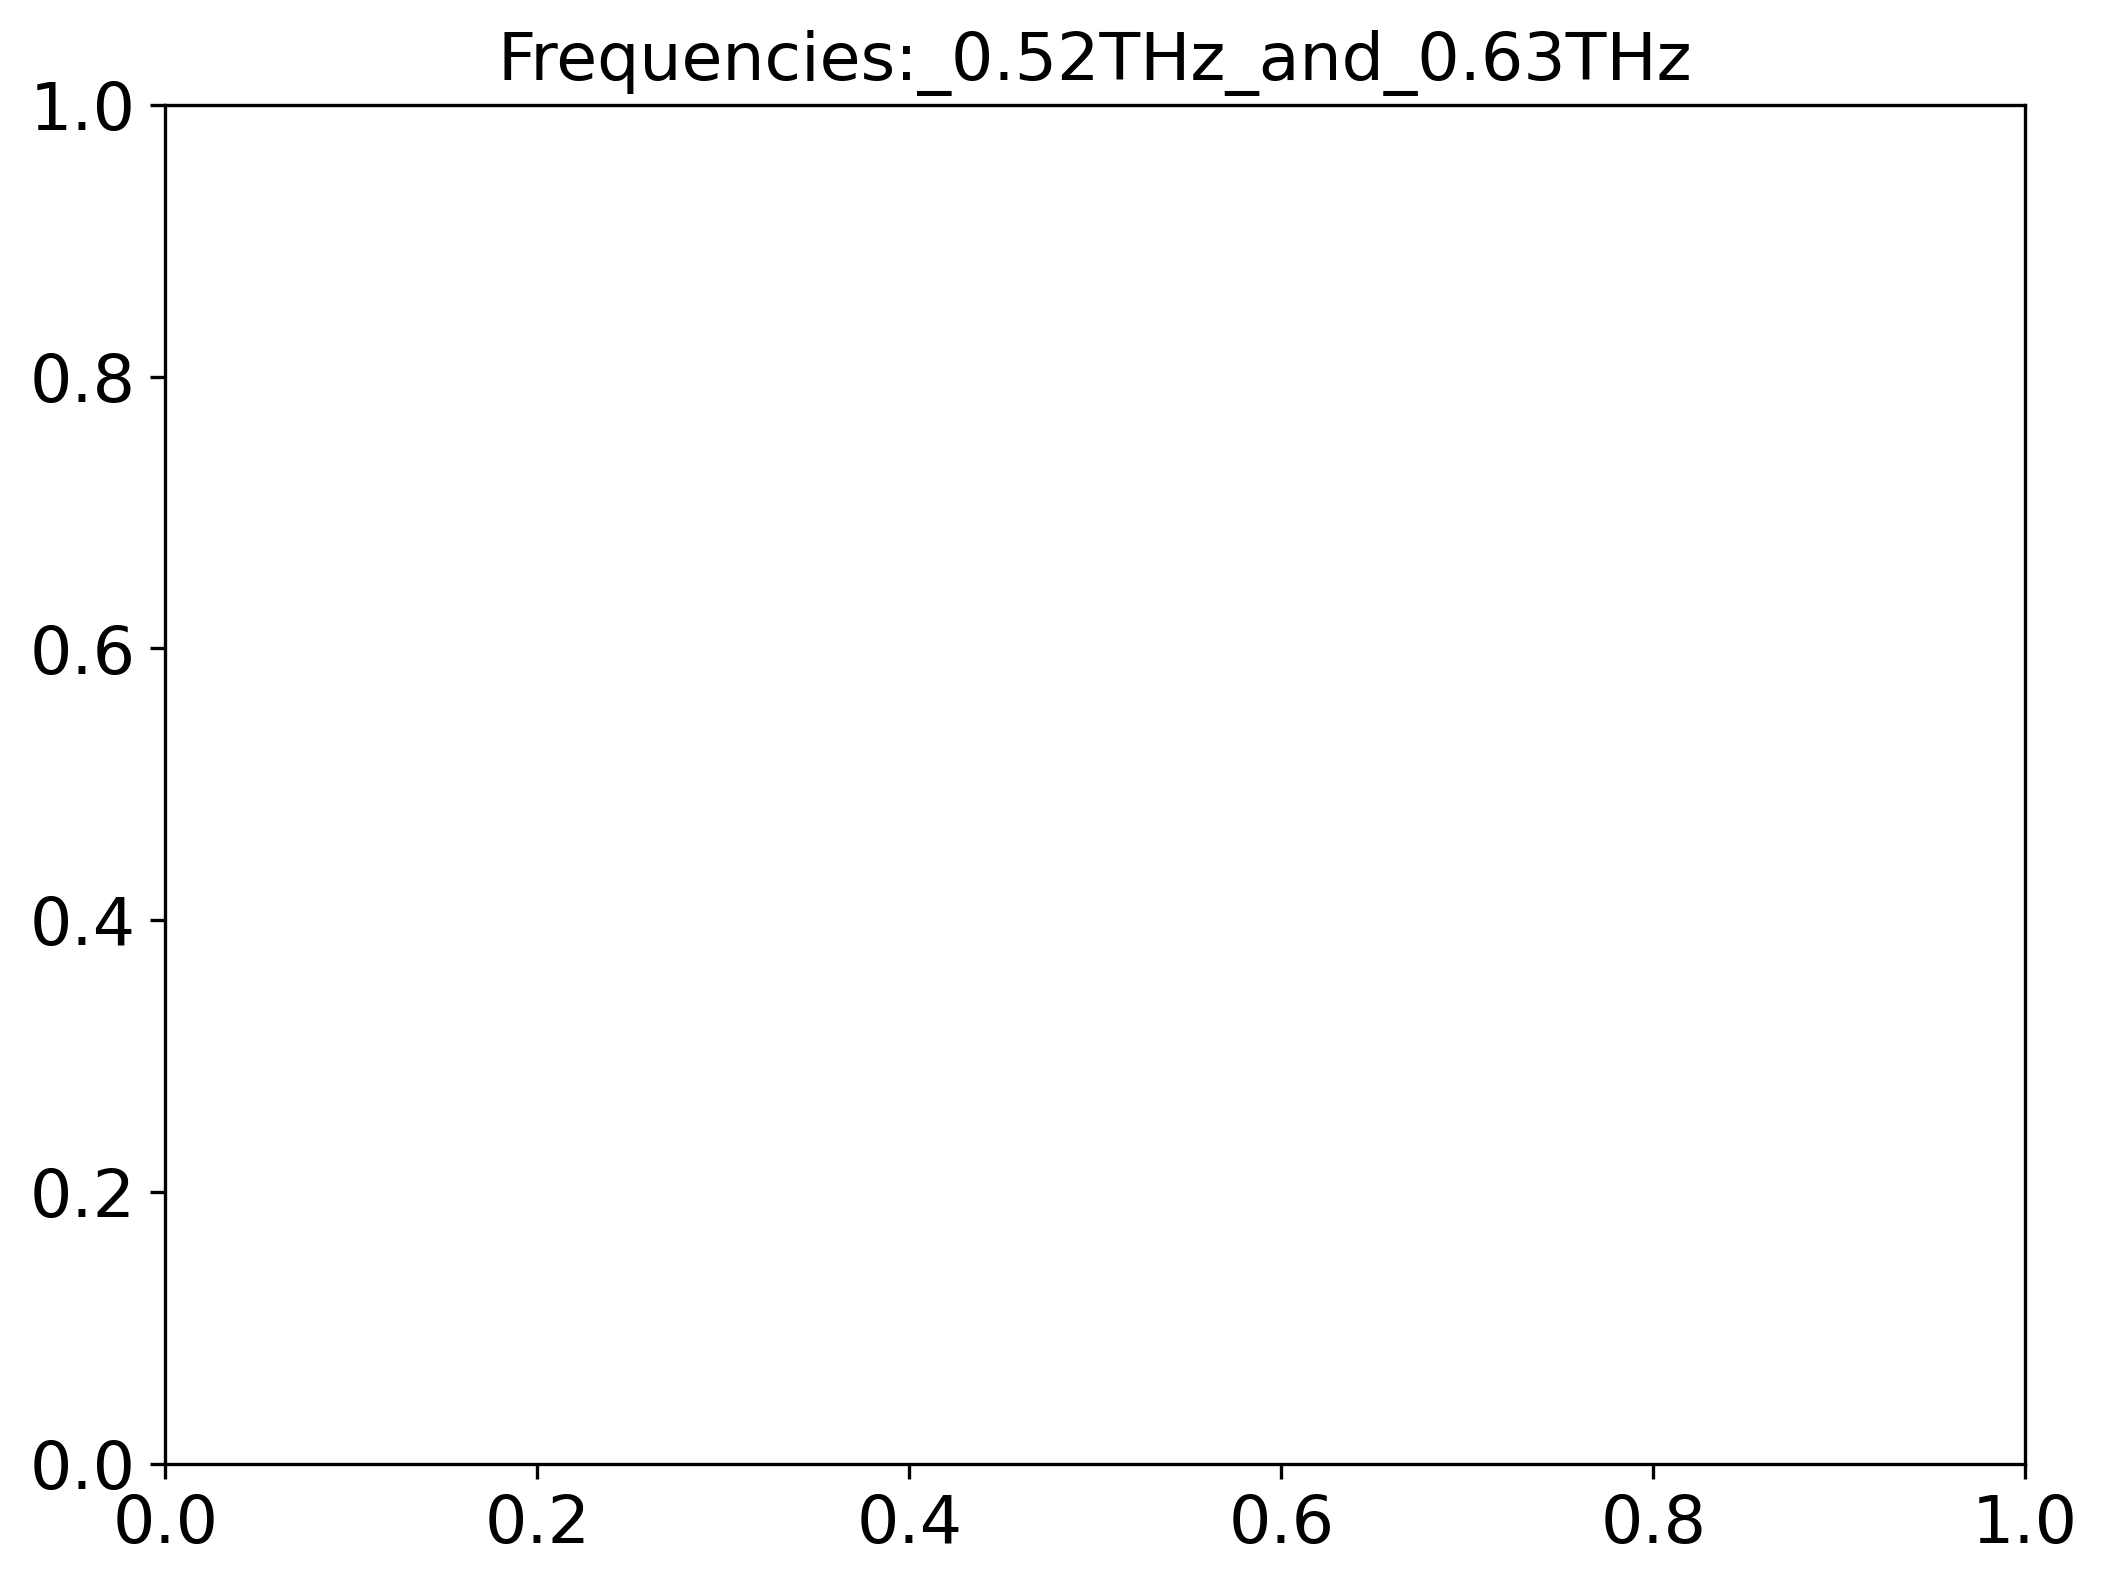

In [54]:
get = [[e052,'0.52THz'], [e063, '0.63THz'], [e072, '0.72THz'], [e082, '0.82THz']]
phase = np.linspace(0, 2 * np.pi, 100)

for i, j in it.combinations(get, 2):
    print('Calculating the combination of {} and {}'.format(i[1], j[1]))
    results = [phase_scan(i[0], j[0], ϕ) for ϕ in phase]
    results_flipped = [phase_scan(j[0], i[0], ϕ) for ϕ in phase]
    transmittance, I_out, I_in = zip(*results)
    transmittance_flipped, I_out_flipped, I_in_flipped = zip(*results_flipped)
    
    title = 'Frequencies:_{}_and_{}'.format(i[1], j[1])
    
    plt.figure()
    plt.title(title)
    plt.plot(phase / np.pi, transmittance, '*-', 
             label="{} + 0.5 {}".format(i[1], j[1]))
    plt.plot(phase / np.pi, transmittance_flipped, '*-', 
             label="{} + 0.5 {}".format(j[1], i[1]))
    plt.xlabel(r"$\varphi$ ($\pi$)")
    plt.ylabel(r"Transmittance")
    plt.legend()
    plt.tight_layout()
    plt.savefig('./Plots/Transmittance_{}.pdf'.format(title))
    plt.show()
    
    plt.figure()
    plt.title(title)
    plt.plot(phase / np.pi, I_out, '*-',
             label="{} + 0.5 {}".format(i[1], j[1]))
    plt.plot(phase / np.pi, I_out_flipped, '*-',
             label="{} + 0.5 {}".format(i[1], j[1]))
    plt.xlabel(r"$\varphi$ ($\pi$)")
    plt.ylabel(r"Transmitted intensity")
    plt.legend()
    plt.tight_layout()
    plt.savefig('./Plots/Transmitted_Intensity_{}.pdf'.format(title))
    plt.show()
    
    title = 'Frequencies:_{}_and_{}_semilogy'.format(i[1], j[1])
    plt.figure()
    plt.title(title)
    plt.semilogy(phase / np.pi, transmittance, '*-',
                label="{} + 0.5 {}".format(i[1], j[1]))
    plt.semilogy(phase / np.pi, transmittance_flipped, '*-',
                label="{} + 0.5 {}".format(j[1], i[1]))
    plt.xlabel(r"$\varphi$ ($\pi$)")
    plt.ylabel(r"Transmittance")
    plt.legend()
    plt.tight_layout()
    plt.savefig('./Plots/Transmittance_{}.pdf'.format(title))
    plt.show()
    
    plt.figure()
    plt.title(title)
    plt.plot(phase / np.pi, I_out, '*-')
    plt.plot(phase / np.pi, I_out_fl, '*-')
    plt.xlabel(r"$\varphi$ ($\pi$)")
    plt.ylabel(r"Transmitted intensity")
    plt.legend()
    plt.tight_layout()
    plt.savefig('./Plots/Transmitted_Intensity_{}.pdf'.format(title))
    plt.show()
    
    plt.close('all')

In [24]:
transmittance, I_out = zip(*results)

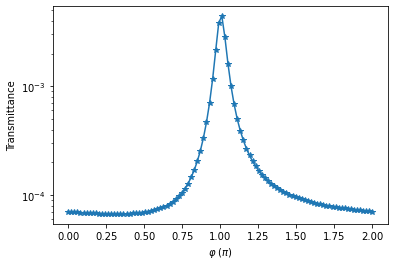

In [21]:
plt.semilogy(phase / np.pi, transmittance, '*-')
plt.xlabel(r"$\varphi$ ($\pi$)")
plt.ylabel(r"Transmittance")
plt.show()

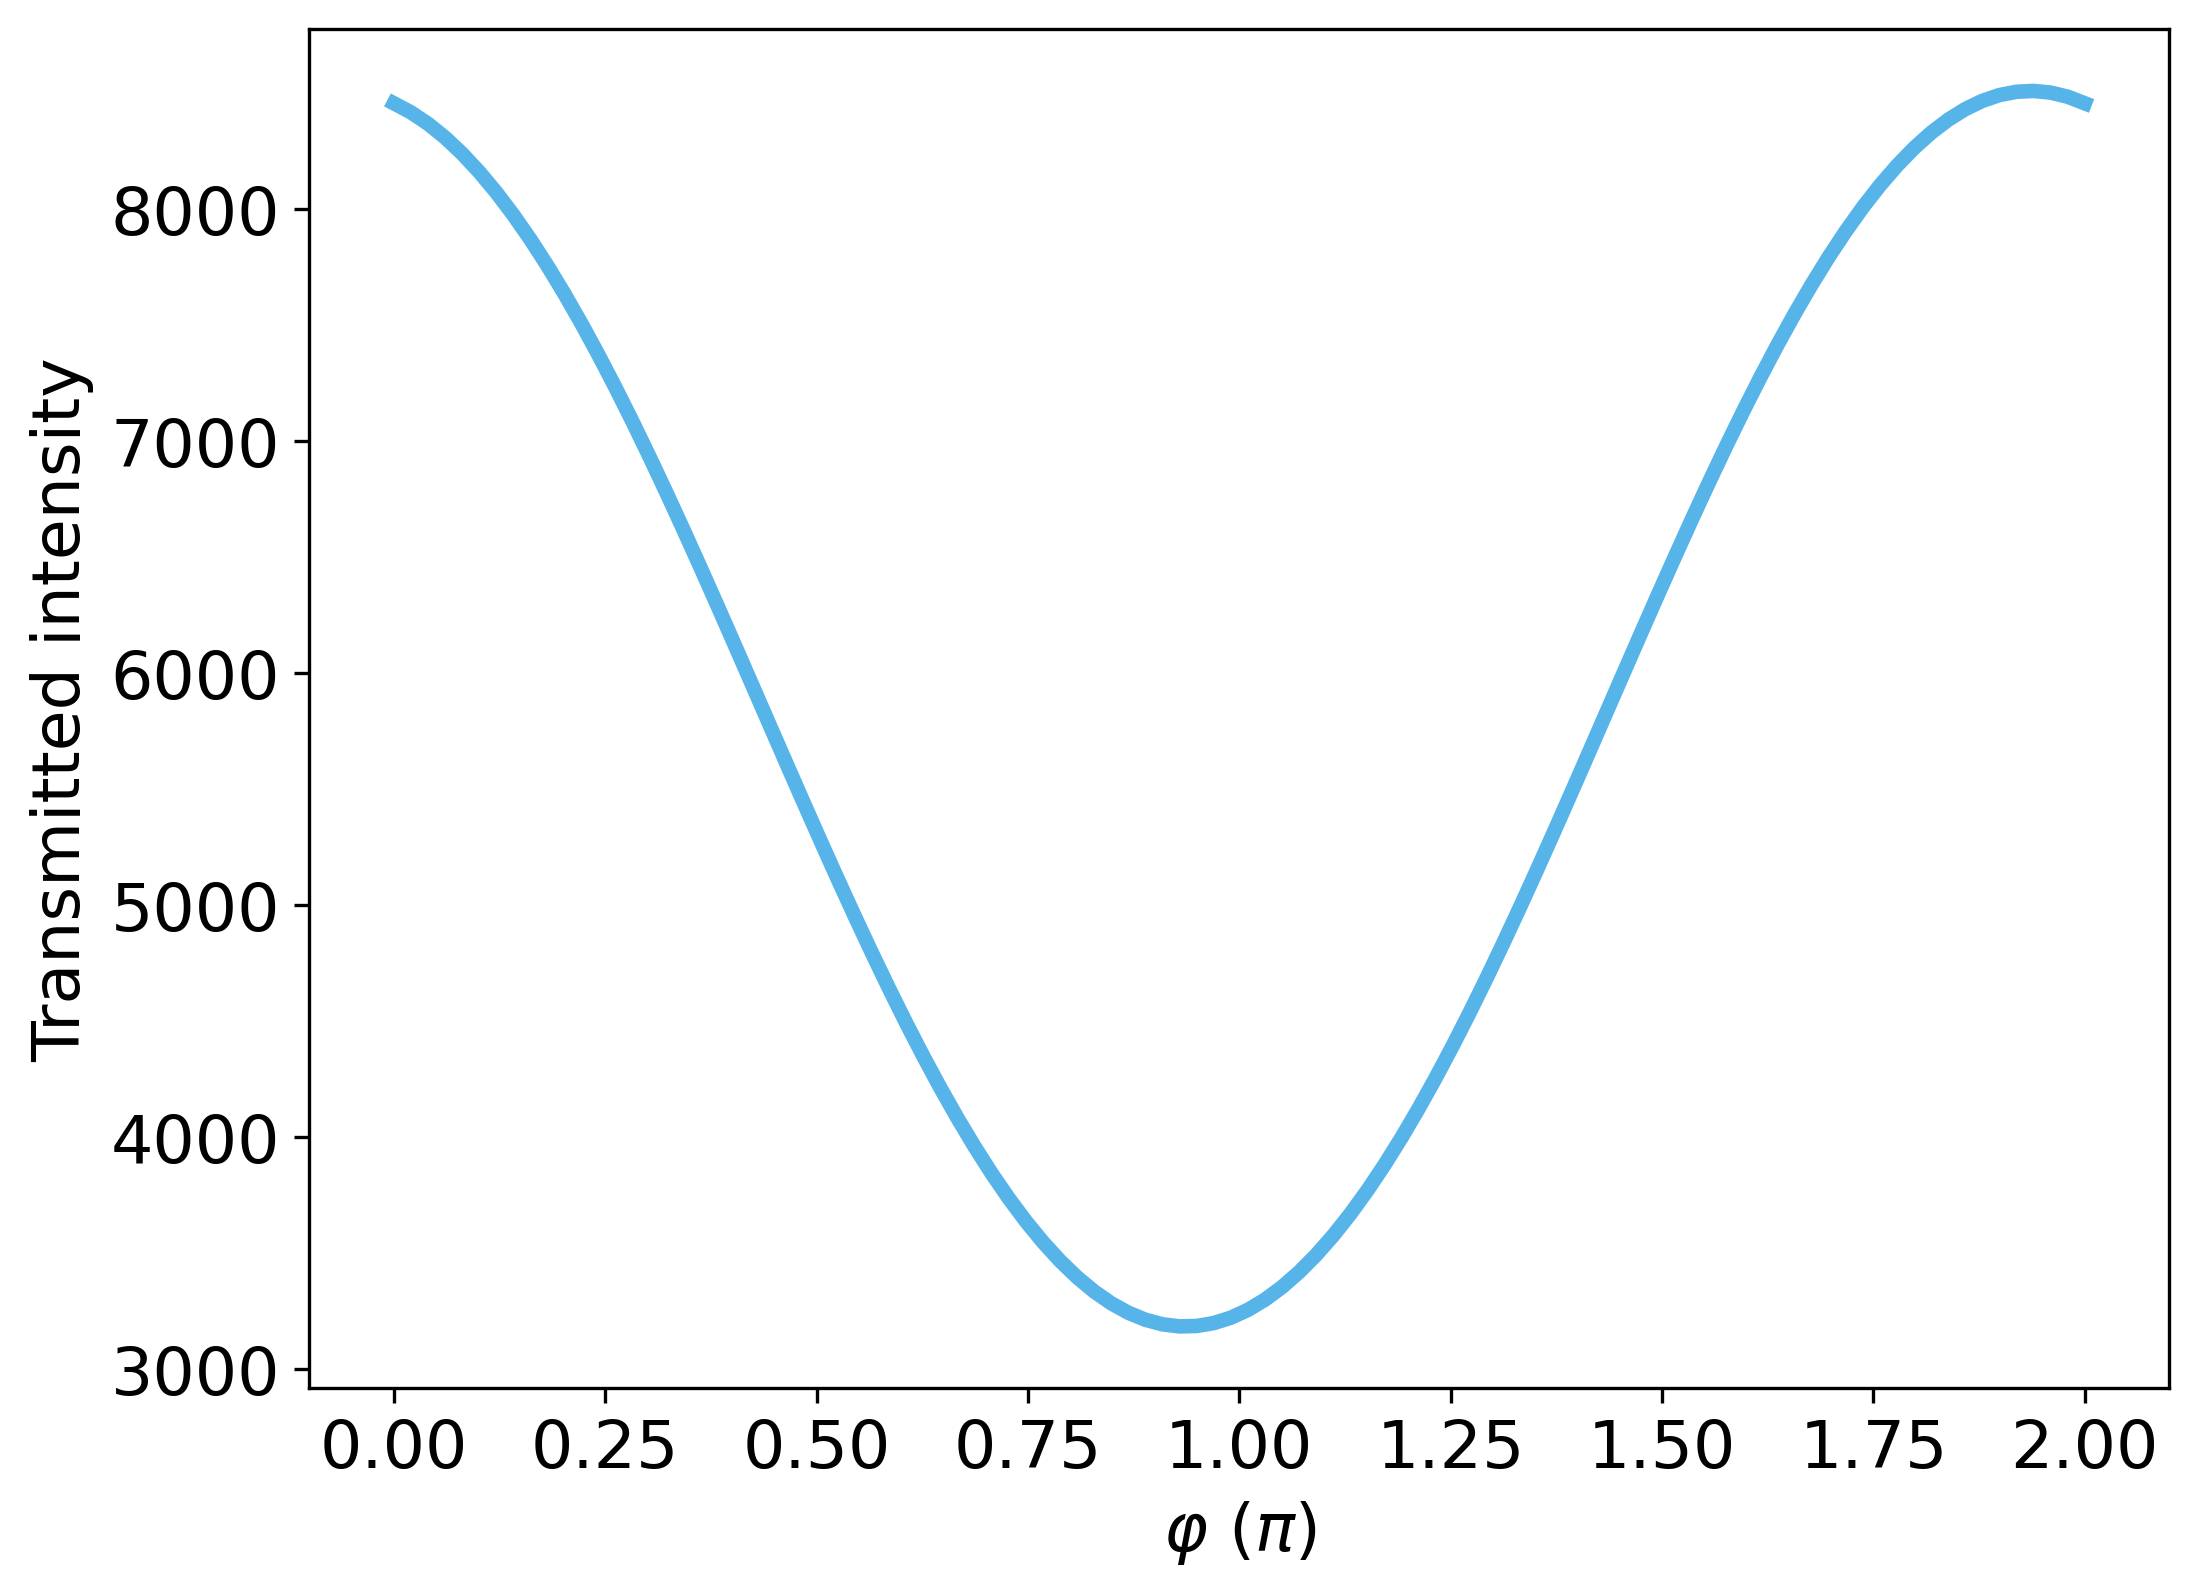

In [37]:
plt.plot(phase / np.pi, I_out)
plt.xlabel(r"$\varphi$ ($\pi$)")
plt.ylabel(r"Transmitted intensity")
plt.show()

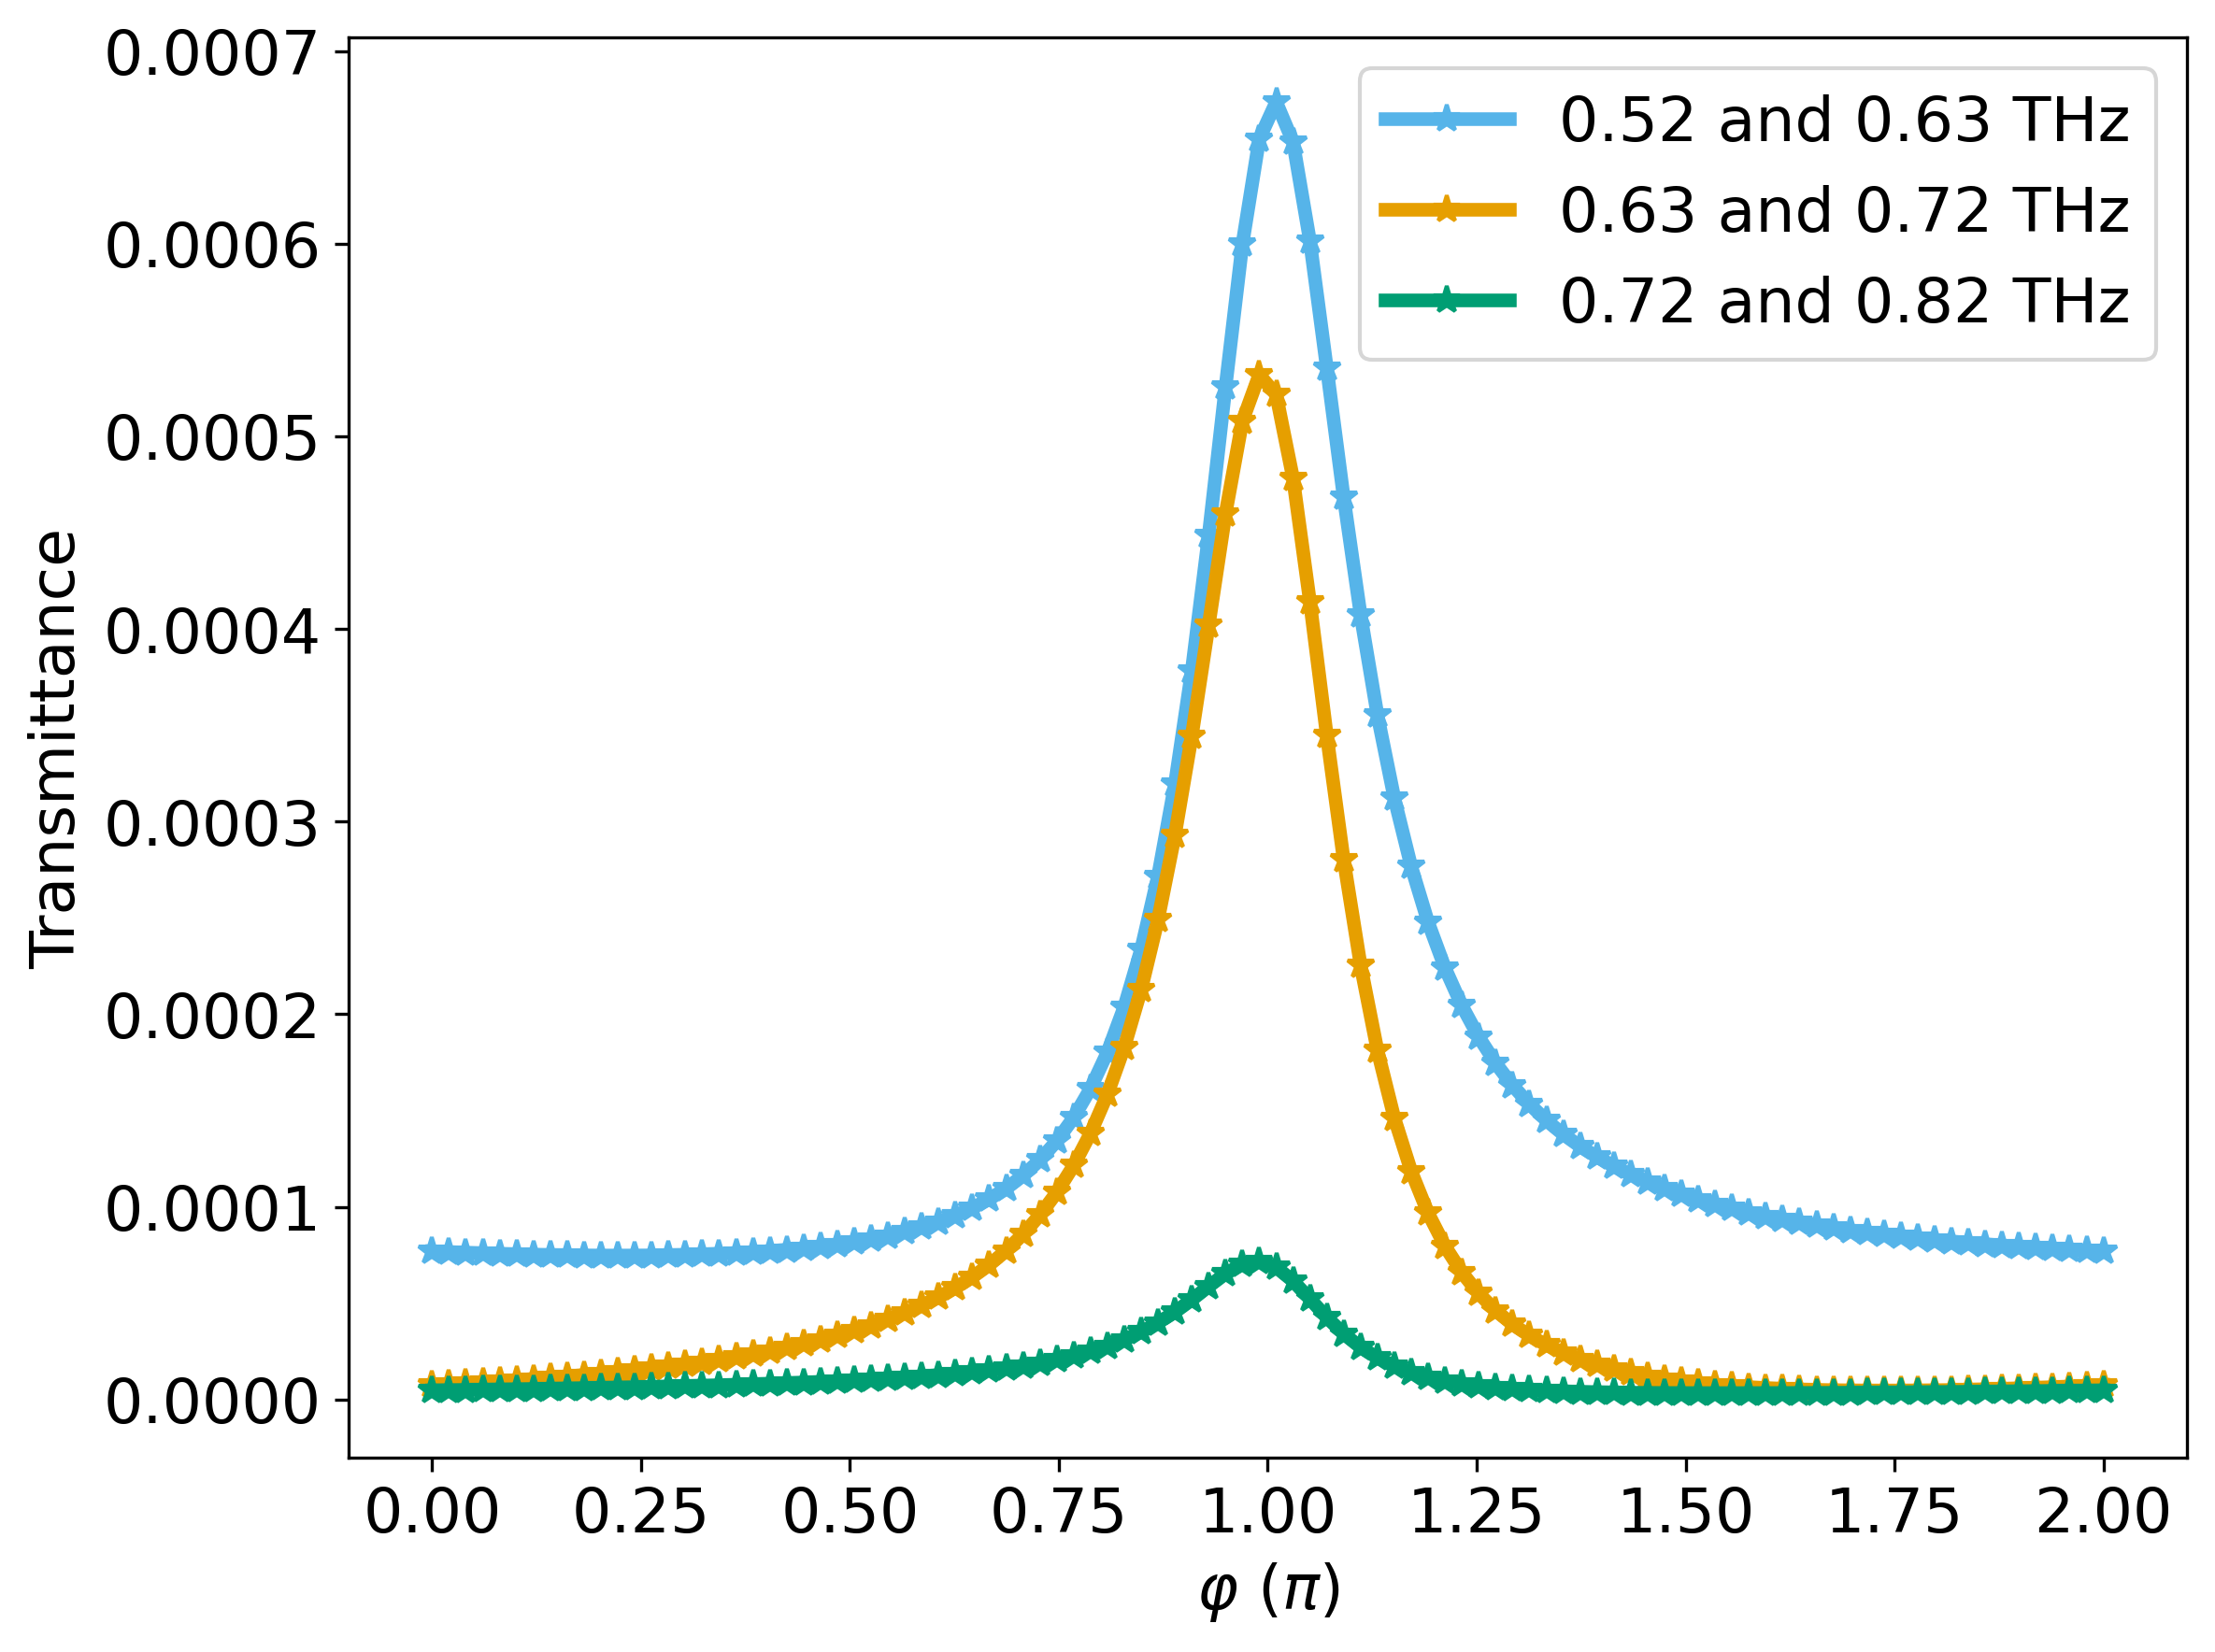

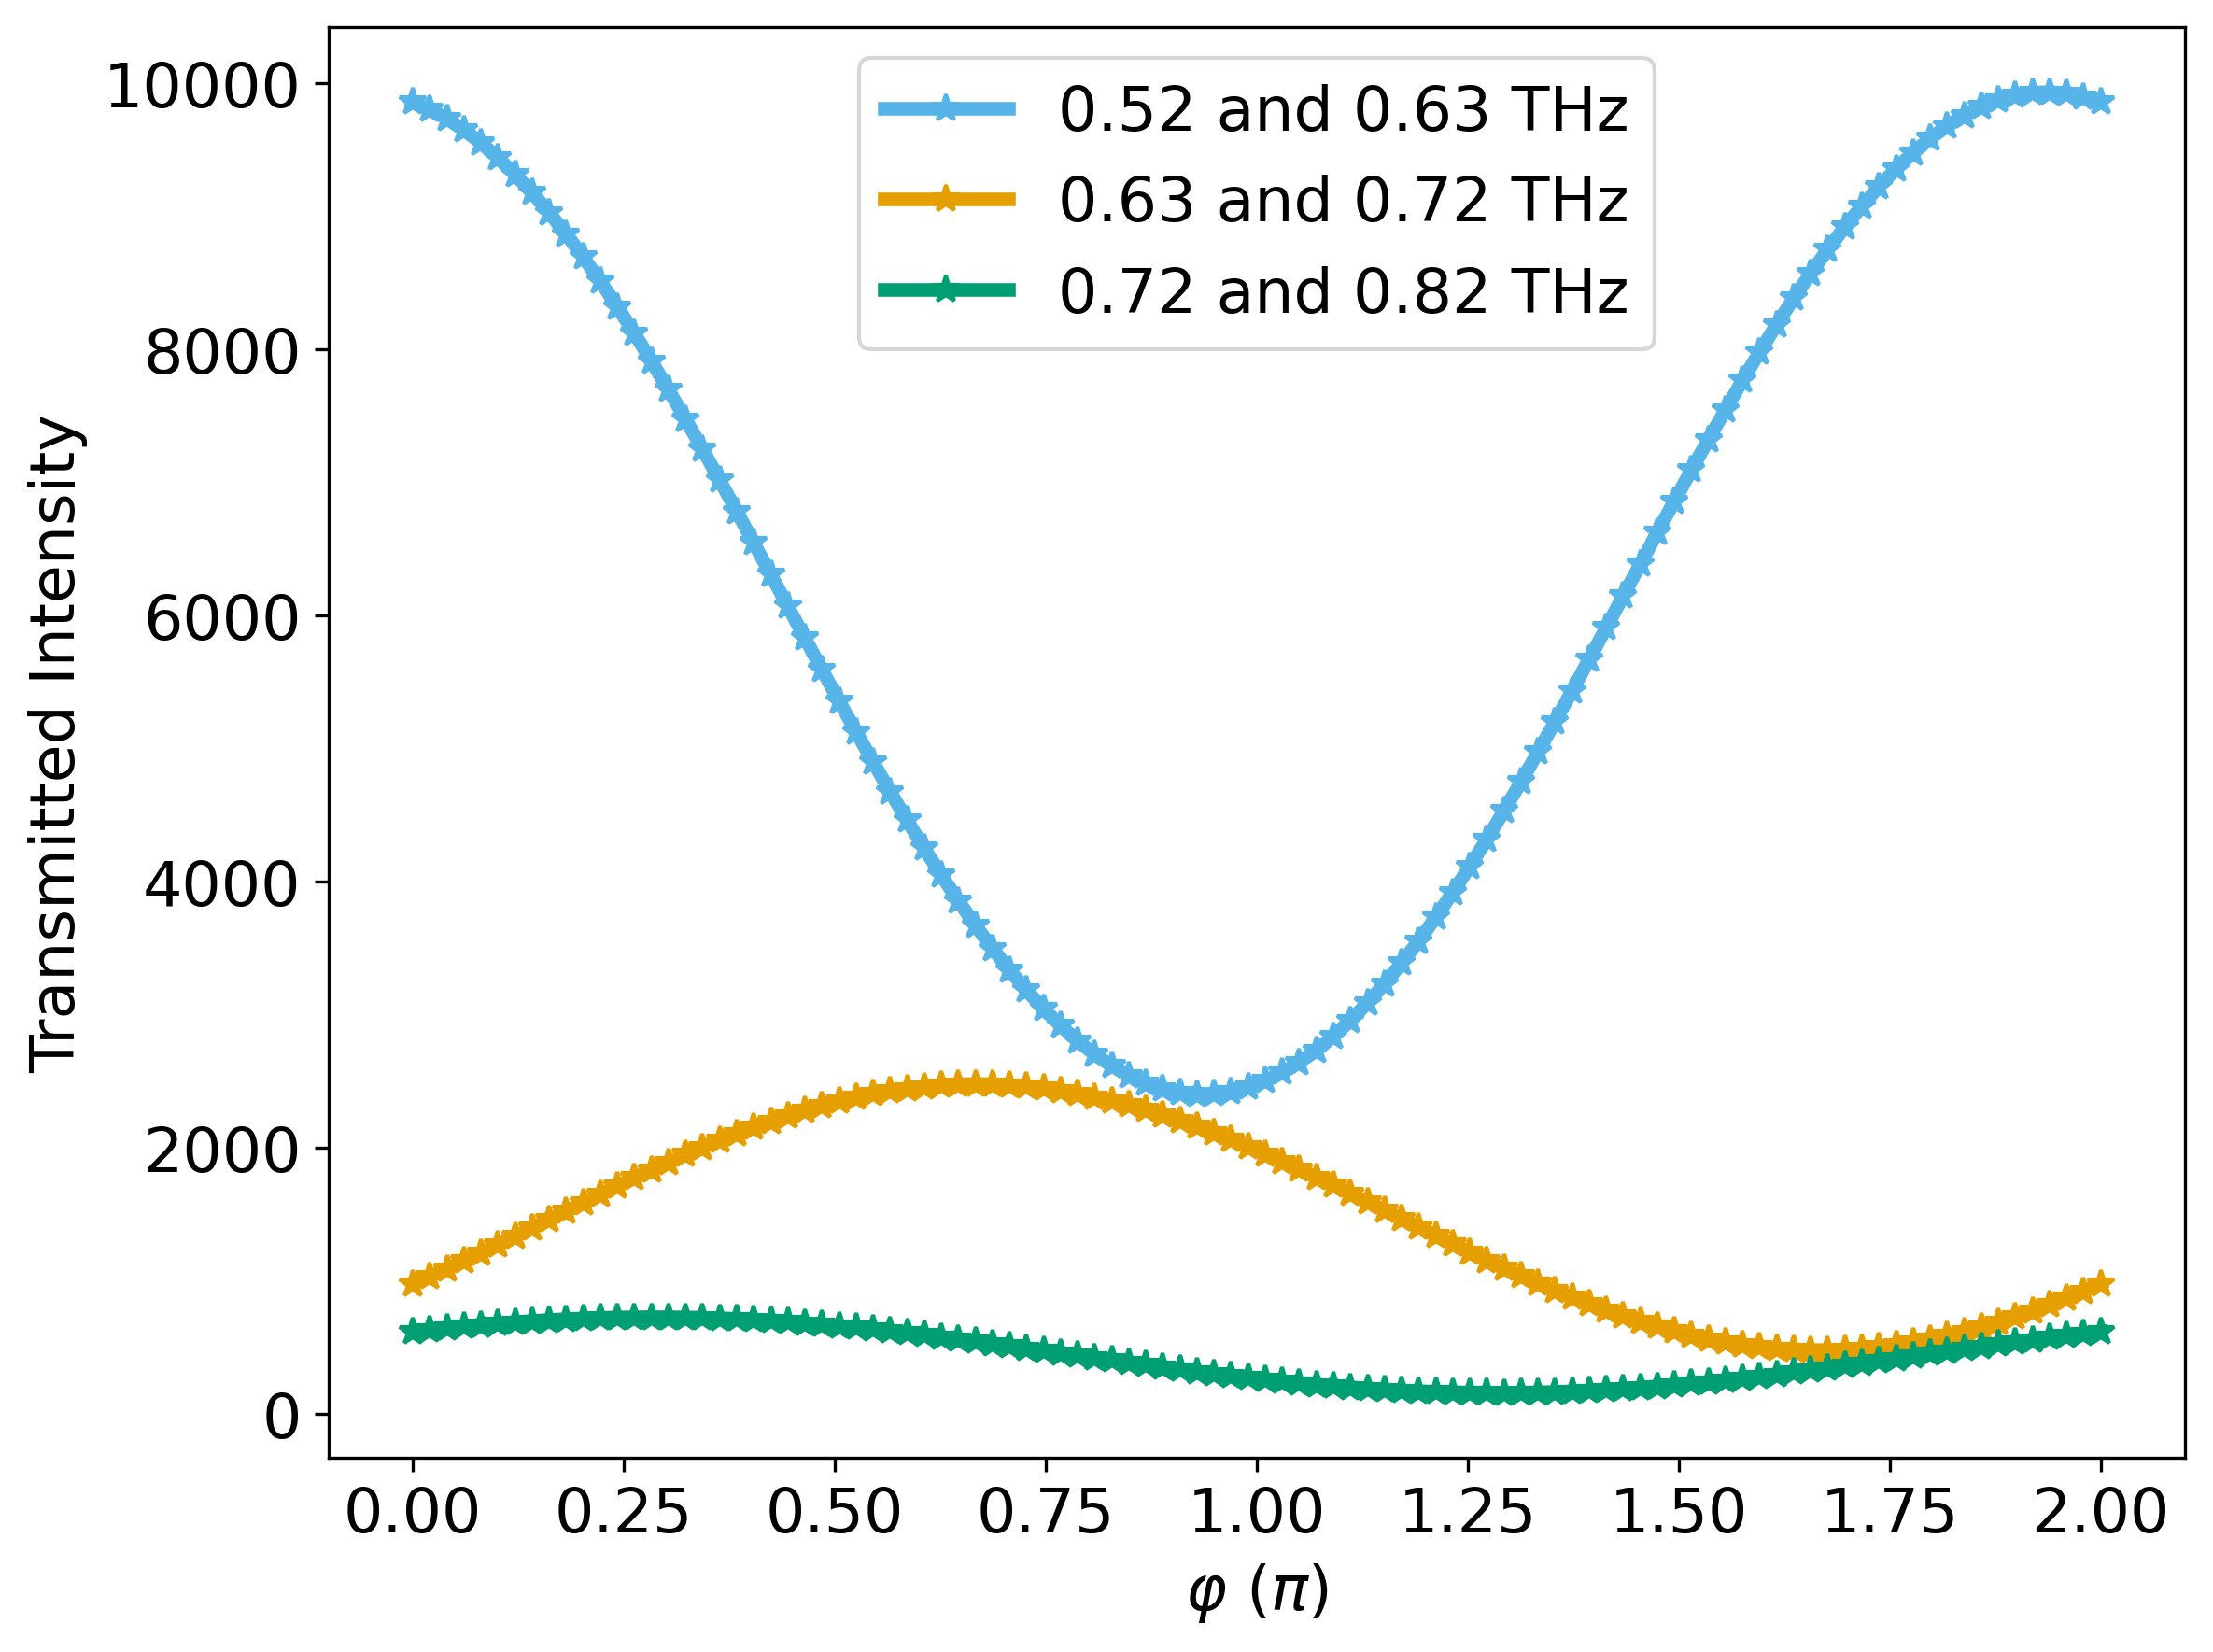

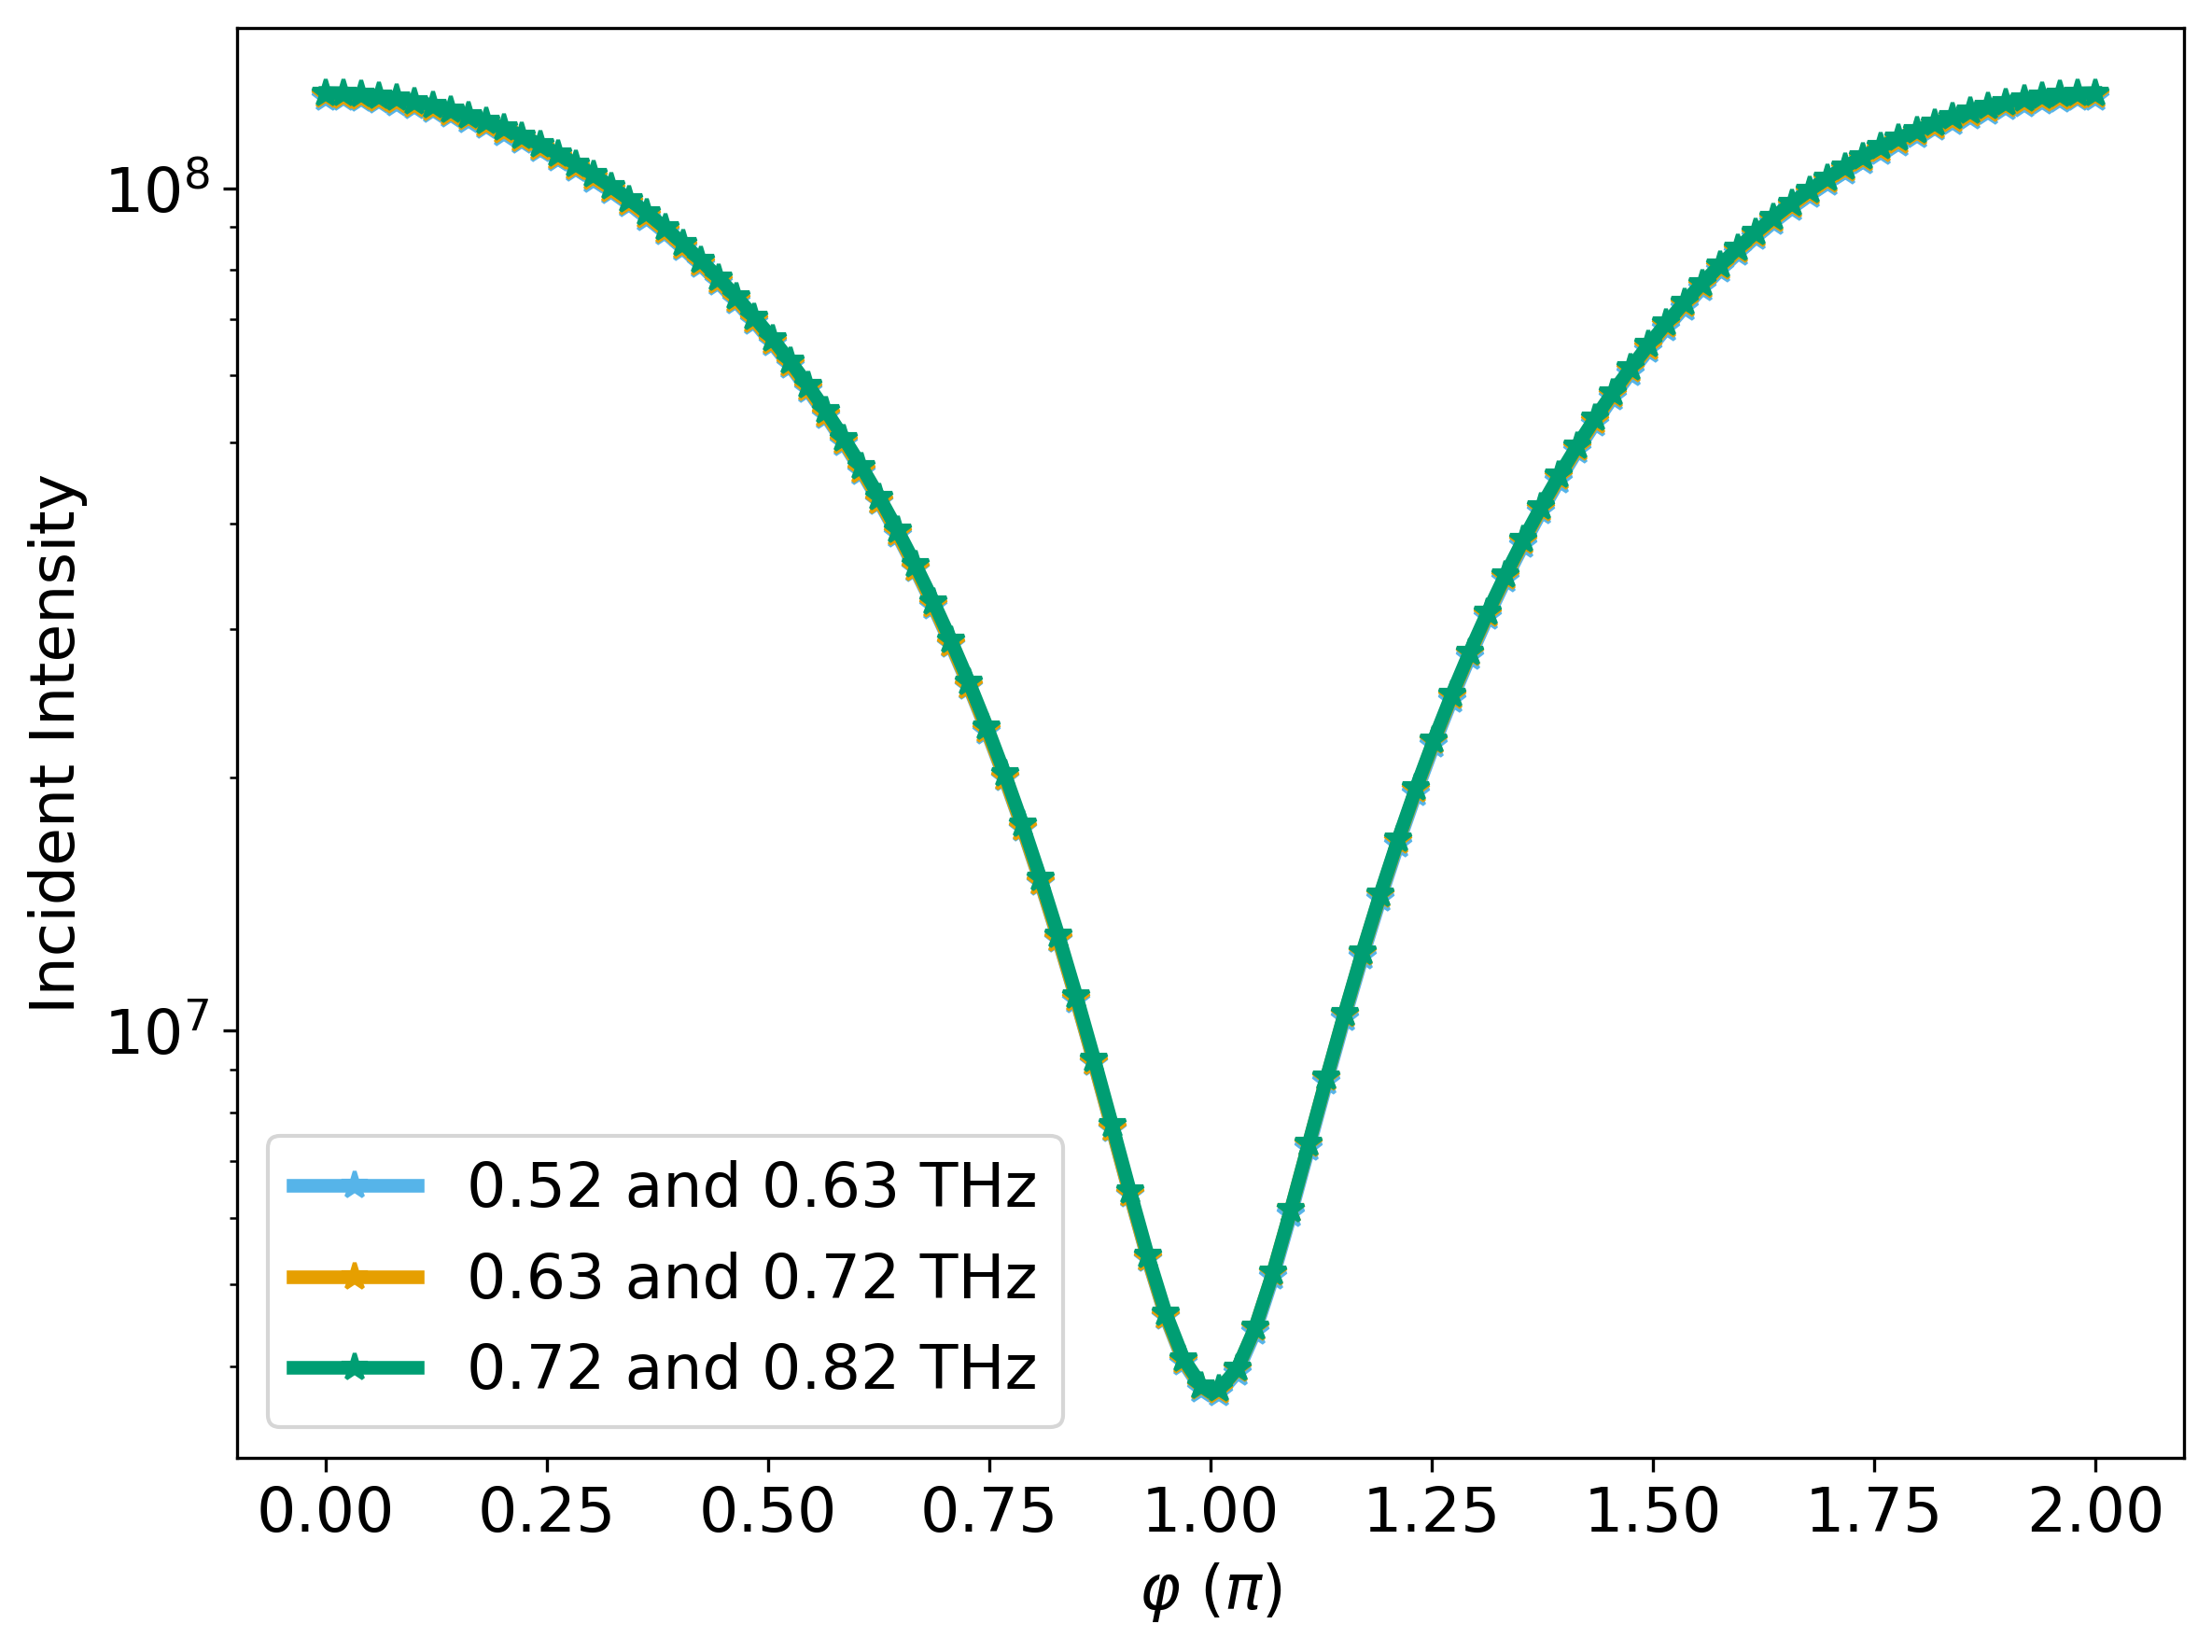

In [49]:
transmittance1, I_out1, I_in1 = zip(*results1)
transmittance2, I_out2, I_in2 = zip(*results2)
transmittance3, I_out3, I_in3 = zip(*results3)

plt.plot(phase / np.pi, transmittance1, '*-', label='0.52 and 0.63 THz')
plt.plot(phase / np.pi, transmittance2, '*-', label='0.63 and 0.72 THz')
plt.plot(phase / np.pi, transmittance3, '*-', label='0.72 and 0.82 THz')
plt.xlabel(r"$\varphi$ ($\pi$)")
plt.ylabel(r"Transmittance")
plt.legend()
plt.tight_layout()
plt.savefig('./Plots/Transmittance_{}.pdf'.format("AllPairs"))
plt.show()

plt.plot(phase / np.pi, I_out1, '*-', label='0.52 and 0.63 THz')
plt.plot(phase / np.pi, I_out2, '*-', label='0.63 and 0.72 THz')
plt.plot(phase / np.pi, I_out3, '*-', label='0.72 and 0.82 THz')
plt.xlabel(r"$\varphi$ ($\pi$)")
plt.ylabel(r"Transmitted Intensity")
plt.legend()
plt.tight_layout()
plt.savefig('./Plots/TransmittedIntensity_{}.pdf'.format("AllPairs"))
plt.show()

plt.semilogy(phase / np.pi, I_in1, '*-', label='0.52 and 0.63 THz')
plt.semilogy(phase / np.pi, I_in2, '*-', label='0.63 and 0.72 THz')
plt.semilogy(phase / np.pi, I_in3, '*-', label='0.72 and 0.82 THz')
plt.xlabel(r"$\varphi$ ($\pi$)")
plt.ylabel(r"Incident Intensity")
plt.legend()
plt.tight_layout()
plt.savefig('./Plots/IncidentIntensity_{}.pdf'.format("AllPairs_Logy"))
plt.show()

In [ ]:
plt.figure(figsize=(6,8), dpi=300)
plt.imshow(get_I(thz052, thz063, np.pi))
plt.colorbar()
plt.show()

In [ ]:
plt.figure(figsize=(6,8), dpi=300)
plt.imshow(get_I(thz052, thz063, 0),
           origin='lower',
           norm=SymLogNorm(linthresh=1e-5))
plt.colorbar()
plt.show()